## Extract LINCS genes from the TC data that we use for becnhmarking feature importance

In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import time
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# Clustering
from sklearn.datasets import make_biclusters, make_checkerboard, make_classification
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralCoclustering, SpectralBiclustering
from sklearn.metrics import consensus_score

# Corr
from scipy.stats import spearmanr, pearsonr
from numpy import corrcoef

# Utils
file_path = os.getcwd()  # os.path.dirname(os.path.relpath(__file__))
utils_path = os.path.abspath(os.path.join(file_path, '..', '..', 'utils_py'))
sys.path.append(utils_path)
import utils_all as utils

# Feature importance
pfi_path = os.path.abspath(os.path.join(file_path, '..', 'pfi'))
sys.path.append(pfi_path)
import pfi
import pfi_utils

import warnings
warnings.filterwarnings('ignore')

SEED=0

Using TensorFlow backend.


In [2]:
OUTDIR = os.path.join(file_path, 'data')
utils.make_dir(OUTDIR)

In [3]:
datapath = '/vol/ml/apartin/Benchmarks/Data/Pilot1/'

data_train_org = pd.read_csv(os.path.join(datapath, 'P1B1.dev.train.csv'), sep=',')
print(data_train_org.shape)

data_val_org = pd.read_csv(os.path.join(datapath, 'P1B1.dev.test.csv'), sep=',')
print(data_val_org.shape)

(3000, 60485)
(1000, 60485)


In [4]:
mm = pd.read_csv(os.path.join(datapath, 'lincs1000.tsv'), sep='\t')

In [5]:
data_train = data_train_org[['case_id', 'cancer_type'] + mm['gdc'].tolist()]  # Extract lincs from the whole dataset
data_val   = data_val_org[['case_id', 'cancer_type'] + mm['gdc'].tolist()]  # Extract lincs from the whole dataset
print(data_train.shape)
print(data_val.shape)

(3000, 980)
(1000, 980)


In [6]:
# Map lincs gene names
col_mapping = {mm.loc[g, 'gdc']: mm.loc[g, 'symbol'] for g in range(mm.shape[0])}
data_train = data_train.rename(columns=col_mapping)
data_val = data_val.rename(columns=col_mapping)

In [7]:
# Sort the gene names
data_train = data_train[['case_id', 'cancer_type'] + sorted(data_train.columns[2:].tolist())]
data_val = data_val[['case_id', 'cancer_type'] + sorted(data_val.columns[2:].tolist())]

In [8]:
data_train.drop(columns='case_id', inplace=True)
data_val.drop(columns='case_id', inplace=True)

In [9]:
data_train.rename(columns={'cancer_type': 'y'}, inplace=True)
data_val.rename(columns={'cancer_type': 'y'}, inplace=True)

In [10]:
data_train['y'].value_counts()

Lung Squamous Cell Carcinoma             300
Head and Neck Squamous Cell Carcinoma    300
Uterine Corpus Endometrial Carcinoma     300
Thyroid Carcinoma                        300
Skin Cutaneous Melanoma                  300
Prostate Adenocarcinoma                  300
Lung Adenocarcinoma                      300
Others                                   300
Brain Lower Grade Glioma                 300
Breast Invasive Carcinoma                300
Name: y, dtype: int64

In [11]:
data_val['y'].value_counts()

Brain Lower Grade Glioma                 100
Thyroid Carcinoma                        100
Lung Squamous Cell Carcinoma             100
Breast Invasive Carcinoma                100
Head and Neck Squamous Cell Carcinoma    100
Skin Cutaneous Melanoma                  100
Uterine Corpus Endometrial Carcinoma     100
Prostate Adenocarcinoma                  100
Others                                   100
Lung Adenocarcinoma                      100
Name: y, dtype: int64

In [12]:
y_train = data_train['y'].values
y_val = data_val['y'].values
y_enc = LabelEncoder()

In [13]:
y_train = y_enc.fit_transform(y_train)
y_val = y_enc.transform(y_val)

In [14]:
y_encoded = pd.DataFrame(data={'label': np.arange(0, len(y_enc.classes_)), 'type': y_enc.classes_})
y_encoded.to_csv(os.path.join(OUTDIR, 'P1B1.y.enc.ap'), sep='\t', index=False)

In [15]:
data_train['y'] = y_train
data_val['y'] = y_val

In [16]:
# Shuffle the training values
data_train = data_train.sample(n=data_train.shape[0], axis=0, replace=False, random_state=SEED).reset_index(drop=True)

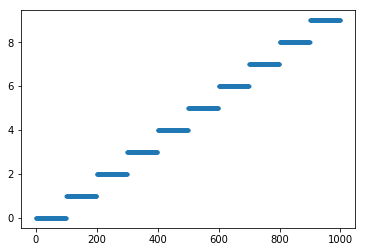

In [17]:
# Sort the val values by the target label
data_val = data_val.sort_values('y', ascending=True).reset_index(drop=True)
plt.plot(data_val['y'], '.');

In [18]:
# data_train.to_csv(os.path.join(file_path, 'data', 'P1B1.dev.train.lincs.csv'), index=False)
# data_val.to_csv(os.path.join(file_path, 'data', 'P1B1.dev.test.lincs.csv'), index=False)
data_train.to_csv(os.path.join(OUTDIR, 'P1B1.dev.train.lincs.ap'), sep='\t', index=False)
data_val.to_csv(os.path.join(OUTDIR, 'P1B1.dev.test.lincs.ap'), sep='\t', index=False)